$ Pregunta \ \ 3 $

$a) $ Investigando sobre boosting llegamos a que boosting es una manera de ensamblar varios modelos debiles de modo que el ensamble sea un modelo de clasificación fuerte. En base a esto, llegamos al siguiente algoritmo presentado en 1996 que consiste en lo siguiente:

$  $

Sean los datos $x_1, ..., x_n$ que pueden ser clasificados como $ -1 $ o como $ + 1 $. Definimos $ w_1(i) = \frac{1}{n} \ \ \forall i \in \lbrace 1,..., n \rbrace $

Para $ t = 1,..., T: $

1. Mulplicamos a los datos $x_1,...,x_n $ por $ w_t(i) $ para cada $ i $ respectivamente. \\

2. Realizar un ajuste logistico $ f_t $.

3. Sea define $ \epsilon_t = \sum_{i=1}^{n} w_{t}(i) \mathbb{1}  \lbrace y_i \neq f_t(x_i) \rbrace $ donde $ \mathbb{1}  \lbrace y_i \neq f_t(x_i) \rbrace $ es $0$ si $ y_i = f_t(x_i) $ y vale $1$ si $ y_i \neq f_t(x_i) $

Para este paso también definimos $ \alpha_t = \frac{1}{2} ln \left( \frac{1-\epsilon_t}{\epsilon_t} \right) $

4. Se actualizan los valores de $ w_{t+1}(i) = w_{t}(i) \cdot e^{-\alpha_t y_i f_t(x_i)} $ y luego se normalizan estos coeficientes de modo que sumen 1. 

Luego de terminar el loop se define el clasificador boosting como:

$ f_{boost}(x) = sign \left( \sum_{t=1}^{T} \alpha_t f_t(x) \right) $

$ $

Como se observa, la idea que esta detrás de este algoritmo es que se ponderan con más peso los datos que fueron mal clasificados.

$ $

$b)$ Ahora implementamos random forest y este algoritmo para las bases de datos que nos dieron, de donde las bases desde el 2014 al 2017 son de entrenamiento y la del 2017 es de testeo. Y luego de eso, se realizará una comparación con la implementación de regresiones logisticas con coeficientes polinomiales. 

$ $

In [1]:
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def producto_punto(x_1, x_2):
    suma = 0
    for i in range(len(x_1)):
        suma = suma + x_1[i]*x_2[i]
    return suma

In [3]:
def funcion_h(theta, x):
    valor = producto_punto(theta, x)
    c = 700
    if valor >= c:
        return 1
    elif valor <= -c:
        return 0
    else:
        resultado = 1/(1 + math.exp(-valor))
        return resultado

In [4]:
# Sean vectores en R^n y m muestras    [[y_1, x^(1)], ..., [y_m, x^(m)]]
# theta es un vector de R^n

def una_iteracion(theta, datos):
    nuevo_theta = []
    for k in range(len(theta)):
        suma = 0
        for i in range(len(datos)):
            suma = suma + (datos[i][0] - funcion_h(theta, datos[i][1]))*datos[i][1][k]
        suma = suma + theta[k]
        nuevo_theta.append(suma)
    return nuevo_theta

In [5]:
def calcular_regresion_logistica(theta_inicial, datos, T):
    theta = theta_inicial
    for t in range(T):
        theta = una_iteracion(theta, datos)
    return theta

In [6]:
def transformacion_punto(punto, d):
    lista = []
    lista.append(1)
    for i in range(d):
        lista.append(punto[0]**(i+1))
    lista.append(punto[1])
    return lista

In [7]:
def metodo_regresion_logistica(d, T):
    
    datos_entrenamiento = []
    
    for k1 in puntos_positivos_entrenamiento:
        datos_entrenamiento.append([1, transformacion_punto(k1, d)])

    for k2 in puntos_negativos_entrenamiento:
        datos_entrenamiento.append([-1, transformacion_punto(k2, d)])
        
    theta_0 = []
           
    for p in range(d+2):
        theta_0.append(p)

    resultado = calcular_regresion_logistica(theta_0, datos_entrenamiento, T)
    
    lista_coeficientes = []

    for i in range(d+1):
        lista_coeficientes.append(-resultado[i]/resultado[d+1])
    
    eje_x = []
    eje_y = []

    for i in range(100):
        eje_x.append(-2+i*0.04)

    for j in eje_x:
        suma = 0
        for k in range(len(lista_coeficientes)):
            suma = suma + lista_coeficientes[k]*(j**k)
        eje_y.append(suma)
        
    return [eje_x, eje_y, resultado, datos_entrenamiento]

In [8]:
def calcular_error(resultado, datos):

    suma = 0
    contador = 0

    for k in datos:
        if (producto_punto(k[1], resultado) >= 0 and k[0] == 1) or (producto_punto(k[1], resultado) <= 0 and k[0] == -1):
            suma = suma + 1
        contador = contador + 1
    
    porcentaje = 100*(suma/contador)
    return porcentaje

In [9]:
# Sean vectores en R^n y m muestras    [[y_1, x^(1)], ..., [y_m, x^(m)]]
# calcular_regresion_logistica(theta_inicial, datos, T)

def crear_datos(base):
    nuevo_data = []
    for i in range(len(base[0])):
        lista = []
        if base[len(base)-1][i] == 1:
            lista.append(1)
        else:
            lista.append(-1)
        new_list = []
        for j in range(len(base)-1):
            new_list.append(base[j][i])
        new_list.append(1)
        lista.append(new_list)
        nuevo_data.append(lista)
    return nuevo_data

In [10]:
def sacar_rango(lista, rango):
    nueva_lista = []
    for i in lista:
        nueva_lista.append(i[rango: rango + 1000])
    return nueva_lista

In [11]:
def creacion_datos_testeo(d):

    datos_testeo= []

    for k1 in puntos_positivos_testeo:
        datos_testeo.append([1, transformacion_punto(k1, d)])

    for k2 in puntos_negativos_testeo:
        datos_testeo.append([-1, transformacion_punto(k2, d)])
    
    return datos_testeo

In [12]:
def random_forest(numero_atributos):
    
    archivo_2014 = pd.read_csv("2014_Financial_Data.csv")
    archivo_2015 = pd.read_csv("2015_Financial_Data.csv")
    archivo_2016 = pd.read_csv("2016_Financial_Data.csv")
    archivo_2017 = pd.read_csv("2017_Financial_Data.csv")
    archivo_2018 = pd.read_csv("2018_Financial_Data.csv")

    lista_atributos = []

    for i in range(numero_atributos):
        lista_atributos.append(random.randint(0, 221))
        
    nombres = []

    for k in archivo_2014:
        nombres.append(k)
    
    nombres.remove(nombres[len(nombres)-2])
    nombres.remove(nombres[0])
    
    nuevos_nombres = []

    for i in range(len(lista_atributos)):
        nuevos_nombres.append(nombres[lista_atributos[i]])
    
    nuevo_archivo_2014 = archivo_2014.dropna(subset=nuevos_nombres)
    nuevo_archivo_2015 = archivo_2015.dropna(subset=nuevos_nombres)
    nuevo_archivo_2016 = archivo_2016.dropna(subset=nuevos_nombres)
    nuevo_archivo_2017 = archivo_2017.dropna(subset=nuevos_nombres)
    nuevo_archivo_2018 = archivo_2018.dropna(subset=nuevos_nombres)
    
    nombres = nuevos_nombres
    
    total_2014 = []

    for k in nombres:
        columna = []
        for j in nuevo_archivo_2014[k]:
            columna.append(j)
        total_2014.append(columna)

    clase_2014 = []
    for i in nuevo_archivo_2014['Class']:
        clase_2014.append(i)

    total_2014.append(clase_2014)

    #-----------------------------------------

    total_2015 = []

    for k in nombres:
        columna = []
        for j in nuevo_archivo_2015[k]:
            columna.append(j)
        total_2015.append(columna)

    clase_2015 = []
    for i in nuevo_archivo_2015['Class']:
        clase_2015.append(i)

    total_2015.append(clase_2015)

    #-----------------------------------------

    total_2016 = []

    for k in nombres:
        columna = []
        for j in nuevo_archivo_2016[k]:
            columna.append(j)
        total_2016.append(columna)

    clase_2016 = []
    for i in nuevo_archivo_2016['Class']:
        clase_2016.append(i)

    total_2016.append(clase_2016)

    #-----------------------------------------

    total_2017 = []

    for k in nombres:
        columna = []
        for j in nuevo_archivo_2017[k]:
            columna.append(j)
        total_2017.append(columna)

    clase_2017 = []
    for i in nuevo_archivo_2017['Class']:
        clase_2017.append(i)

    total_2017.append(clase_2017)

    #-----------------------------------------

    total_2018 = []

    for k in nombres:
        columna = []
        for j in nuevo_archivo_2018[k]:
            columna.append(j)
        total_2018.append(columna)

    clase_2018 = []
    for i in nuevo_archivo_2018['Class']:
        clase_2018.append(i)

    total_2018.append(clase_2018)

    #-----------------------------------------
    
    diccionario_eleccion = {1: total_2014, 2: total_2015, 3: total_2016, 4: total_2017}

    numero_iteraciones = 10

    bases = []

    for k in range(numero_iteraciones):
        year = random.randint(1, 4)
        rango = random.randint(0, 500)
        base = sacar_rango(diccionario_eleccion[year], rango)
        bases.append(base)    
    
    # Aplicacion de Random Forest

    thetas_r_f = []
    T = 100

    for k in range(numero_iteraciones):
        datos_input = crear_datos(bases[k]) 
        theta_inicial = []
        for i in range(len(bases[k])):
            theta_inicial.append(0.5)
        theta_output = calcular_regresion_logistica(theta_inicial, datos_input, T)
        thetas_r_f.append(theta_output)
    
    theta_r_f_def = []

    for i in range(len(thetas_r_f[0])):
        theta_r_f_def.append(0)

    for j in range(len(thetas_r_f[0])):
        for i in range(len(thetas_r_f)):
            theta_r_f_def[j] = theta_r_f_def[j] + thetas_r_f[i][j]
        theta_r_f_def[j] = theta_r_f_def[j]/len(thetas_r_f)
    
    datos_input = crear_datos(total_2018)
    theta_output = theta_r_f_def
    
    contador = 0
    correcto = 0

    for i in range(len(datos_input)):
        contador = contador + 1
        if np.sign(-producto_punto(datos_input[i][1], theta_output)) == datos_input[i][0]:
            correcto = correcto + 1
    
    return 100*(correcto/contador)

In [13]:
def calcular_regresion_polinomial(numero_atributo, d, T):
    
    archivo_2014 = pd.read_csv("2014_Financial_Data.csv")
    archivo_2015 = pd.read_csv("2015_Financial_Data.csv")
    archivo_2016 = pd.read_csv("2016_Financial_Data.csv")
    archivo_2017 = pd.read_csv("2017_Financial_Data.csv")
    archivo_2018 = pd.read_csv("2018_Financial_Data.csv")
    
    nombres = []

    for k in archivo_2014:
        nombres.append(k)
    
    nombres.remove(nombres[len(nombres)-2])
    nombres.remove(nombres[0])

    nuevo_nombre = [nombres[numero_atributo]]  # Desde el 0 hasta el 221
    
    # Eliminar los datos NAN
    
    nuevo_archivo_2014 = archivo_2014.dropna(subset=nuevo_nombre)
    nuevo_archivo_2015 = archivo_2015.dropna(subset=nuevo_nombre)
    nuevo_archivo_2016 = archivo_2016.dropna(subset=nuevo_nombre)
    nuevo_archivo_2017 = archivo_2017.dropna(subset=nuevo_nombre)
    nuevo_archivo_2018 = archivo_2018.dropna(subset=nuevo_nombre)
    
    data_final_2014 = calcular_base_datos(nuevo_archivo_2014, nuevo_nombre, d)
    data_final_2015 = calcular_base_datos(nuevo_archivo_2015, nuevo_nombre, d)
    data_final_2016 = calcular_base_datos(nuevo_archivo_2016, nuevo_nombre, d)
    data_final_2017 = calcular_base_datos(nuevo_archivo_2017, nuevo_nombre, d)
    data_final_2018 = calcular_base_datos(nuevo_archivo_2018, nuevo_nombre, d)
    
    data_entrenamiento = []

    for k in range(len(data_final_2014)):
        data_entrenamiento.append(data_final_2014[k])

    for k in range(len(data_final_2015)):
        data_entrenamiento.append(data_final_2015[k])

    for k in range(len(data_final_2016)):
        data_entrenamiento.append(data_final_2016[k])

    for k in range(len(data_final_2017)):
        data_entrenamiento.append(data_final_2017[k])

    data_testeo = data_final_2018
    
    nuevo_theta = []
    for i in range(d+1):
        nuevo_theta.append(0.5)

    output = calcular_regresion_logistica(nuevo_theta, data_entrenamiento, T)
    
    contador = 0
    correcto = 0

    for i in data_entrenamiento:
        if np.sign(producto_punto(i[1], output)) == i[0]:
            correcto = correcto + 1
        contador = contador + 1
    
    precision_entrenamiento = 100*(correcto/contador)
    
    
    contador = 0
    correcto = 0

    for i in data_testeo:
        if np.sign(producto_punto(i[1], output)) == i[0]:
            correcto = correcto + 1
        contador = contador + 1

    precision_testeo = 100*(correcto/contador)
    
    return [precision_entrenamiento, precision_testeo]

In [14]:
def calcular_base_datos(nuevo_archivo, nuevo_nombre, d):  #NUEVO NOMBRE ES DEL TIPO [[nuevo_nombre]]
    lista = []
    for i in nuevo_archivo[nuevo_nombre[0]]:
        lista.append(i)
    
    clase = []
    for j in nuevo_archivo['Class']:
        clase.append(int(2*j-1))
    
    nueva_data = []
    
    for k in range(len(lista)):
        
        vector = []
        
        for h in range(d+1):
            vector.append(lista[k]**h)
        
        vector_ext = [clase[k], vector]
        
        nueva_data.append(vector_ext)
    
    return nueva_data

In [15]:
def multiplicar_data(data, w):  #data y w tienen que tener el mismo largo
    nueva_data = []
    for i in range(len(data)):
        data[i][0] # esto tiene que seguir igual
        new_list = []
        for j in range(len(data[i][1])):
            new_list.append(data[i][1][j]*w[i])
        nueva_data.append([data[i][0], new_list])
    return nueva_data

In [16]:
random.seed(2211)

$ $

$ Random \ Forest $ 

$ $ 

Aquí realizamos la implementación de random forest (la parte de seleccionar aleatoriamente los atributos y que elementos de los atributos se hace en la definición de la función de random forest). Como se observa hicimos un analisis de como era el rendimiento (en el testeo) de este algoritmo en función del número de atributos que este poseia y llegamos a que el optimo era cuando son $ 4 $ atributos obteniendo una precisión del 78.34 %.

$ $ 

In [17]:
N = 11
precisiones = []
eje_n = []

for n in range(1, N+1):
    start = time.time()
    precision = random_forest(n)
    precisiones.append(precision)
    eje_n.append(n)
    end = time.time()
    print("Iteración: ", n)
    print("Tiempo: ", end-start)


Iteración:  1
Tiempo:  5.338791608810425
Iteración:  2
Tiempo:  7.182851314544678
Iteración:  3
Tiempo:  9.891092538833618
Iteración:  4
Tiempo:  13.249605894088745
Iteración:  5
Tiempo:  16.082818508148193
Iteración:  6
Tiempo:  20.455551385879517
Iteración:  7
Tiempo:  21.410568714141846
Iteración:  8
Tiempo:  24.711820125579834
Iteración:  9
Tiempo:  27.030163526535034
Iteración:  10
Tiempo:  33.05694103240967
Iteración:  11
Tiempo:  35.95303273200989


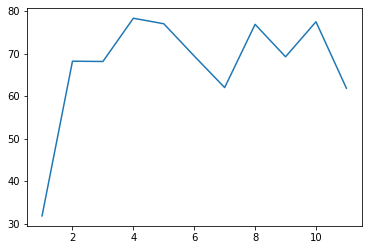

In [18]:
plt.plot(eje_n, precisiones)
plt.show()

In [19]:
max(precisiones)

78.34471675371634

$ $

$ Regresion \ Logística \ Polinomial $

$ $

Aca lo que hicimos fue calcular regresiones logisticas polinomiales hasta de grado $10$. Luego realizamos estos para todos los atributos y así llegamos a que el que mejor resultados tenía era el 9 y es por esto que utilizamos este atributo en la siguiente parte y mostramos el rendimiento en función del grado de polinomio. Como se observa, cuando el grado es 2 se obtiene el máximo con una precisión de 69.15 %.

$ $ 

In [20]:
D = 10
T = 100

eje_d = []
resultados_testeo = []

for d in range(1, D+1):
    start = time.time()
    output = calcular_regresion_polinomial(9, d, T)
    end = time.time()
    print("Iteración: ", d)
    print("Tiempo: ", end-start)
    resultados_testeo.append(output[1])
    eje_d.append(d)

Iteración:  1
Tiempo:  6.864367723464966
Iteración:  2
Tiempo:  10.241169929504395
Iteración:  3
Tiempo:  13.523295640945435
Iteración:  4
Tiempo:  18.313962697982788
Iteración:  5
Tiempo:  23.393739700317383
Iteración:  6
Tiempo:  26.876543283462524
Iteración:  7
Tiempo:  34.360257387161255
Iteración:  8
Tiempo:  40.33940505981445
Iteración:  9
Tiempo:  41.96425914764404
Iteración:  10
Tiempo:  50.450488567352295


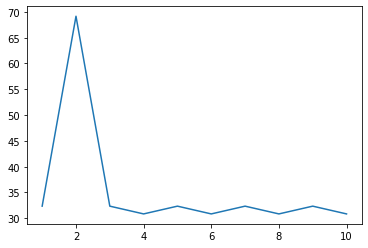

In [21]:
plt.plot(eje_d, resultados_testeo)
plt.show()

In [22]:
indice_max = resultados_testeo.index(max(resultados_testeo))
print(eje_d[indice_max])

2


In [23]:
max(resultados_testeo)

69.15065956954408

$ $

$ Boosting $

Aquí comienza la implementación de boosting en donde realizamos 10 iteraciones y obtuvimos una precisión de 68.1 %. 

$ $

In [24]:
archivo_2014 = pd.read_csv("2014_Financial_Data.csv")
archivo_2015 = pd.read_csv("2015_Financial_Data.csv")
archivo_2016 = pd.read_csv("2016_Financial_Data.csv")
archivo_2017 = pd.read_csv("2017_Financial_Data.csv")
archivo_2018 = pd.read_csv("2018_Financial_Data.csv")

In [25]:
nombres = []

for k in archivo_2014:
        nombres.append(k)
    
nombres.remove(nombres[len(nombres)-2])
nombres.remove(nombres[0])

In [26]:
nombres = nombres[0:10]

In [27]:
nombres.append('Class')

In [28]:
# Eliminar los datos NAN
    
nuevo_archivo_2014 = archivo_2014.dropna(subset=nombres)
nuevo_archivo_2015 = archivo_2015.dropna(subset=nombres)
nuevo_archivo_2016 = archivo_2016.dropna(subset=nombres)
nuevo_archivo_2017 = archivo_2017.dropna(subset=nombres)
nuevo_archivo_2018 = archivo_2018.dropna(subset=nombres)

In [29]:
nueva_data_2014 = []

for k in nombres:
    lista = []
    for j in nuevo_archivo_2014[k]:
        lista.append(j)
    nueva_data_2014.append(lista)

nueva_data_2015 = []

for k in nombres:
    lista = []
    for j in nuevo_archivo_2015[k]:
        lista.append(j)
    nueva_data_2015.append(lista)

nueva_data_2016 = []

for k in nombres:
    lista = []
    for j in nuevo_archivo_2016[k]:
        lista.append(j)
    nueva_data_2016.append(lista)

nueva_data_2017 = []

for k in nombres:
    lista = []
    for j in nuevo_archivo_2017[k]:
        lista.append(j)
    nueva_data_2017.append(lista)

nueva_data_2018 = []

for k in nombres:
    lista = []
    for j in nuevo_archivo_2018[k]:
        lista.append(j)
    nueva_data_2018.append(lista)

In [30]:
# Creacion de la data de entrenamiento

data_entrenamiento = []

for k in range(len(nueva_data_2014[0])):
    lista = []
    for j in range(10):
        lista.append(nueva_data_2014[j][k])
    lista.append(1)
    
    data_entrenamiento.append([int(2*nueva_data_2014[10][k]-1), lista])

for k in range(len(nueva_data_2015[0])):
    lista = []
    for j in range(10):
        lista.append(nueva_data_2015[j][k])
    lista.append(1)
    
    data_entrenamiento.append([int(2*nueva_data_2015[10][k]-1), lista])

for k in range(len(nueva_data_2016[0])):
    lista = []
    for j in range(10):
        lista.append(nueva_data_2016[j][k])
    lista.append(1)
    
    data_entrenamiento.append([int(2*nueva_data_2016[10][k]-1), lista])

for k in range(len(nueva_data_2017[0])):
    lista = []
    for j in range(10):
        lista.append(nueva_data_2017[j][k])
    lista.append(1)
    
    data_entrenamiento.append([int(2*nueva_data_2017[10][k]-1), lista])

In [31]:
data_testeo = []

for k in range(len(nueva_data_2018[0])):
    lista = []
    for j in range(10):
        lista.append(nueva_data_2018[j][k])
    lista.append(1)
    
    data_testeo.append([int(2*nueva_data_2018[10][k]-1), lista])

In [32]:
#------------------------------------------ INICIALIZACION

In [33]:
w = []
for j in range(len(data_entrenamiento)):
    w.append(1/len(data_entrenamiento))

In [34]:
data = multiplicar_data(data_entrenamiento, w)

In [35]:
theta_inicial = []

for j in range(11):
    theta_inicial.append(0.5)

In [36]:
iteraciones = 10
T = 100
coeficientes_iter = []
alphas = []

for t in range(iteraciones):
    
    start = time.time()
    
    #CALCULO DE LOS COEFICIENTES
    coeficientes = calcular_regresion_logistica(theta_inicial, data, T)
    coeficientes_iter.append(coeficientes)
    
    #CALCULO DE LAS PREDICCIONES
    predicciones = []
    for i in data:
        predicciones.append(np.sign(producto_punto(i[1], coeficientes)))
    
    #COMPARACIONES
    comparaciones = []
    for i in range(len(data)):
        if data[i][0] == predicciones[i]:
            comparaciones.append(0)
        else:
            comparaciones.append(1)
    
    #CALCULO DEL EPSILON_t y ALPHA_t
    epsilon = producto_punto(comparaciones, w)
    
    alpha = (1/2)*math.log((1-epsilon)/epsilon)
    alphas.append(alpha)
    
    #CALCULAR NUEVAMENTE LOS W
    
    for k in range(len(w)):
        w[k] = w[k]*math.exp(-alpha*(-2*comparaciones[k] + 1))
    
    promedio = np.mean(w)*len(w)
    
    for h in range(len(w)):
        w[h] = w[h]/promedio
    
    data = multiplicar_data(data, w)
    
    end = time.time()
    
    print("Iteración: ", t)
    print("Tiempo: ", end-start)
    print("---------------------")

Iteración:  0
Tiempo:  45.82380509376526
---------------------
Iteración:  1
Tiempo:  135.94422888755798
---------------------
Iteración:  2
Tiempo:  145.2872862815857
---------------------
Iteración:  3
Tiempo:  144.29131960868835
---------------------
Iteración:  4
Tiempo:  139.8437156677246
---------------------
Iteración:  5
Tiempo:  140.70438051223755
---------------------
Iteración:  6
Tiempo:  142.76404213905334
---------------------
Iteración:  7
Tiempo:  156.3052339553833
---------------------
Iteración:  8
Tiempo:  155.5019223690033
---------------------
Iteración:  9
Tiempo:  157.78442645072937
---------------------


In [37]:
#coeficientes_iter
#alphas

nuevos_coeficientes = []

for i in range(len(alphas)):
    new_coef = []
    for j in range(len(coeficientes_iter[i])):
        new_coef.append(coeficientes_iter[i][j]*alphas[i])
    nuevos_coeficientes.append(new_coef)

In [38]:
coeficientes_definitivos = []

for i in range(len(nuevos_coeficientes)):
    if i == 0:
        coeficientes_definitivos.append(nuevos_coeficientes[0])
    else:
        nuevo_elemento = []
        for j in range(len(nuevos_coeficientes[i])):
            nuevo_elemento.append(nuevos_coeficientes[i][j] + coeficientes_definitivos[i-1][j])
        coeficientes_definitivos.append(nuevo_elemento)

In [39]:
precision_entrenamiento = []
eje_n = []

for i in range(len(coeficientes_definitivos)):
    coeficientes_definitivos[i]
    
    contador = 0
    correcto = 0
    
    for j in data_entrenamiento:
        if np.sign(producto_punto(j[1], coeficientes_definitivos[i])) == j[0]:
            correcto = correcto + 1
        contador = contador + 1
    
    precision_entrenamiento.append((correcto/contador)*100)
    eje_n.append(i+1)

In [40]:
precision_testeo = []
eje_n = []

for i in range(len(coeficientes_definitivos)):
    coeficientes_definitivos[i]
    
    contador = 0
    correcto = 0
    
    for j in data_testeo:
        if np.sign(producto_punto(j[1], coeficientes_definitivos[i])) == j[0]:
            correcto = correcto + 1
        contador = contador + 1
    
    precision_testeo.append((correcto/contador)*100)
    eje_n.append(i+1)

In [41]:
precision_testeo[0]

68.07170542635659

$ $ 

$ Analisis \ de \ todos \ los \ metodos $ 

$ $ 

Notemos que en todos los métodos se obtienen precisiones muy altas, por ende podemos decir que todos son buenos. Sin embargo, tanto en boosting como regresiones polinomiales se obtienen precisiones similares que son cercanas al 70 %, a diferencia de random forest que se obtiene una precisión cercana al 80% por ende, decimos que el mejor método es el de random forest. \\



$ $ 

$ BONUS $ 

$ $

Para el bonus el método alternativo que propusimos es un método basado en los valores P de los coeficientes de las regresiones lineales. Para esta lo que hacemos es realizar una regresión lineal para cada una de las variables en donde obtenemos los valores P para cada uno de estos casos. Una vez hecho esto, se realiza el siguiente experimento (Como recordatorio, entre menor valor P, mejor, porque hay más probabilidades de que el coeficiente sea distinto a 0):

Se define un porcentaje y se elijen todos los coeficiente que tienen valor P menor a ese porcentaje y se realiza una regresión con todos estas variables. Luego de eso se calcula el error de testeo. Así graficamos el error en función de ese porcentaje y obtenemos el porcentaje optimo y ese estaría siendo nuestro modelo a utilizar.

Recordemos que la regresión de esta parte ya no es logistica, sino que es sobre el valor de Variación Porcentual. 

$ $

In [42]:
import time
import random
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [43]:
def transformacion_datos(X, d):
    nuevo_X = []
    for i in range(len(X)):
        lista = []
        for j in range(d):
            lista.append(X[i][0]**(j+1))
        nuevo_X.append(lista)
    return nuevo_X

In [44]:
archivo_2014 = pd.read_csv("2014_Financial_Data.csv")
archivo_2015 = pd.read_csv("2015_Financial_Data.csv")
archivo_2016 = pd.read_csv("2016_Financial_Data.csv")
archivo_2017 = pd.read_csv("2017_Financial_Data.csv")
archivo_2018 = pd.read_csv("2018_Financial_Data.csv")

In [45]:
def implementacion_polinomial(numero_atributo):
    
    nombres_2014 = []

    for k in archivo_2014:
        nombres_2014.append(k)
    
    nombres_2014.remove(nombres_2014[len(nombres_2014)-1])
    nombres_2014.remove(nombres_2014[0])

    #--------------------------------------------

    nombres_2015 = []

    for k in archivo_2015:
        nombres_2015.append(k)
    
    nombres_2015.remove(nombres_2015[len(nombres_2015)-1])
    nombres_2015.remove(nombres_2015[0])

    #--------------------------------------------

    nombres_2016 = []

    for k in archivo_2016:
        nombres_2016.append(k)
    
    nombres_2016.remove(nombres_2016[len(nombres_2016)-1])
    nombres_2016.remove(nombres_2016[0])

    #--------------------------------------------

    nombres_2017 = []

    for k in archivo_2017:
        nombres_2017.append(k)
    
    nombres_2017.remove(nombres_2017[len(nombres_2017)-1])
    nombres_2017.remove(nombres_2017[0])

    #--------------------------------------------

    nombres_2018 = []

    for k in archivo_2018:
        nombres_2018.append(k)
    
    nombres_2018.remove(nombres_2018[len(nombres_2018)-1])
    nombres_2018.remove(nombres_2018[0])
    
    nombres_2014 = []

    for k in archivo_2014:
        nombres_2014.append(k)
    
    nombres_2014.remove(nombres_2014[len(nombres_2014)-1])
    nombres_2014.remove(nombres_2014[0])

    #--------------------------------------------

    nombres_2015 = []

    for k in archivo_2015:
        nombres_2015.append(k)
    
    nombres_2015.remove(nombres_2015[len(nombres_2015)-1])
    nombres_2015.remove(nombres_2015[0])

    #--------------------------------------------

    nombres_2016 = []

    for k in archivo_2016:
        nombres_2016.append(k)
    
    nombres_2016.remove(nombres_2016[len(nombres_2016)-1])
    nombres_2016.remove(nombres_2016[0])

    #--------------------------------------------

    nombres_2017 = []

    for k in archivo_2017:
        nombres_2017.append(k)
    
    nombres_2017.remove(nombres_2017[len(nombres_2017)-1])
    nombres_2017.remove(nombres_2017[0])

    #--------------------------------------------

    nombres_2018 = []

    for k in archivo_2018:
        nombres_2018.append(k)
    
    nombres_2018.remove(nombres_2018[len(nombres_2018)-1])
    nombres_2018.remove(nombres_2018[0])
    
    #--------------------------------------------
    
    nuevos_nombres_2014 = []
    nuevos_nombres_2015 = []
    nuevos_nombres_2016 = []
    nuevos_nombres_2017 = []
    nuevos_nombres_2018 = []

    nuevos_nombres_2014.append(nombres_2014[numero_atributo])
    nuevos_nombres_2014.append(nombres_2014[len(nombres_2014)-1])

    nuevos_nombres_2015.append(nombres_2015[numero_atributo])
    nuevos_nombres_2015.append(nombres_2015[len(nombres_2015)-1])

    nuevos_nombres_2016.append(nombres_2016[numero_atributo])
    nuevos_nombres_2016.append(nombres_2016[len(nombres_2016)-1])

    nuevos_nombres_2017.append(nombres_2017[numero_atributo])
    nuevos_nombres_2017.append(nombres_2017[len(nombres_2017)-1])

    nuevos_nombres_2018.append(nombres_2018[numero_atributo])
    nuevos_nombres_2018.append(nombres_2018[len(nombres_2018)-1])
    
    # Se eliminan los datos NAN

    nuevo_archivo_2014 = archivo_2014.dropna(subset=nuevos_nombres_2014)
    nuevo_archivo_2015 = archivo_2015.dropna(subset=nuevos_nombres_2015)
    nuevo_archivo_2016 = archivo_2016.dropna(subset=nuevos_nombres_2016)
    nuevo_archivo_2017 = archivo_2017.dropna(subset=nuevos_nombres_2017)
    nuevo_archivo_2018 = archivo_2018.dropna(subset=nuevos_nombres_2018)
    
    X_entrenamiento = []
    Y_entrenamiento = []

    #------------------------------------

    for k in nuevo_archivo_2014[nuevos_nombres_2014[0]]:
        X_entrenamiento.append([k])

    for h in nuevo_archivo_2014[nuevos_nombres_2014[1]]:
        Y_entrenamiento.append(h)

    #------------------------------------

    for k in nuevo_archivo_2015[nuevos_nombres_2015[0]]:
        X_entrenamiento.append([k])

    for h in nuevo_archivo_2015[nuevos_nombres_2015[1]]:
        Y_entrenamiento.append(h)

    #------------------------------------

    for k in nuevo_archivo_2016[nuevos_nombres_2016[0]]:
        X_entrenamiento.append([k])

    for h in nuevo_archivo_2016[nuevos_nombres_2016[1]]:
        Y_entrenamiento.append(h)

    #------------------------------------

    for k in nuevo_archivo_2017[nuevos_nombres_2017[0]]:
        X_entrenamiento.append([k])

    for h in nuevo_archivo_2017[nuevos_nombres_2017[1]]:
        Y_entrenamiento.append(h)

    #------------------------------------
    
    X_testeo = []
    Y_testeo = []

    #------------------------------------

    for k in nuevo_archivo_2018[nuevos_nombres_2018[0]]:
        X_testeo.append([k])

    for h in nuevo_archivo_2018[nuevos_nombres_2018[1]]:
        Y_testeo.append(h)

    #------------------------------------
    
    D = 10
    errores = []
    eje_d = []

    for d in range(1, D+1):    
        nuevo_X = transformacion_datos(X_entrenamiento, d)
        nuevo_Y = Y_entrenamiento
        reg = LinearRegression().fit(np.array(nuevo_X), np.array(nuevo_Y))
        coeficientes = list(reg.coef_)
        coeficientes.append(reg.intercept_)
    
        X_testing = transformacion_datos(X_testeo, d)
    
        predicciones = []
    
        error_abs = []
    
        for i in range(len(Y_testeo)):
            suma = 0
            for j in range(len(coeficientes)-1):
                suma = suma + X_testing[i][j]*coeficientes[j]
            suma = suma + coeficientes[len(coeficientes)-1]
            predicciones.append(suma)
            error_abs.append(abs(suma-Y_entrenamiento[i])) 
    
        error = np.mean(error_abs)
        
        errores.append(error)
        eje_d.append(d)
    
    return [errores, eje_d]

$ $

$ Implementacion \ Polinomial $

$ $

Ahora pasamos a mostrar la implementación polinomial. Lo que haremos es que para cada variable calculamos la regresión hasta polinomio de grado $10$ y elegimos el minimo. Luego de esto hacemos esto para todas las variables y graficamos el error en función del número de variable. Luego de esto, escogemos este valor que minimiza que para nuestro caso es el parametro 205 con un error de 41.69 (Este error es el error promedio normal i.e. $ \sum_{i=1}^{n} \frac{|valor real - valor predecido|}{n} $), y luego graficamos para este parametro su error en función del grado polinomial y nos damos cuenta que este error se da para el polinomio de grado 1. 

$ $

In [46]:
eje_n = []
minimo_error = []
tiempo_acumulado = 0

for n in range(220):
    start = time.time()
    output = implementacion_polinomial(n)
    eje_n.append(n)
    minimo_error.append(min(output[0]))
    end = time.time()
    tiempo_acumulado = tiempo_acumulado + (end-start)
    if n % 20 == 0:
        print("Iteración: ", n)
        print("Tiempo: ", tiempo_acumulado)

Iteración:  0
Tiempo:  1.8056635856628418
Iteración:  20
Tiempo:  34.07206964492798
Iteración:  40
Tiempo:  68.02072954177856
Iteración:  60
Tiempo:  101.74775290489197
Iteración:  80
Tiempo:  136.27077722549438
Iteración:  100
Tiempo:  165.39680075645447
Iteración:  120
Tiempo:  194.8295669555664
Iteración:  140
Tiempo:  227.13695693016052
Iteración:  160
Tiempo:  261.00642251968384
Iteración:  180
Tiempo:  293.8235037326813
Iteración:  200
Tiempo:  325.877254486084


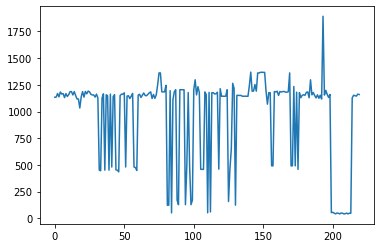

In [47]:
plt.plot(eje_n, minimo_error)
plt.show()

In [48]:
min(minimo_error)

41.69642159127139

In [49]:
n_minimo = eje_n[minimo_error.index(min(minimo_error))]

In [50]:
n_minimo

205

In [51]:
output = implementacion_polinomial(n_minimo)

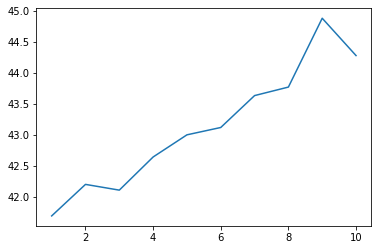

In [52]:
plt.plot(output[1], output[0])
plt.show()

$ $ 

$ Random \ Forest $ 

$ $

Ahora aplicamos Random Forest y para este caso pondremos como variable el número de atributos utilizado en este algoritmo y graficaremos el error en función de este número de atributos. Como se observa en el grafico presentado, el minimo se da cuando se escogen 9 parametros y para este caso se obtiene un error promedio (Este error es el error promedio normal i.e. $ \sum_{i=1}^{n} \frac{|valor real - valor predecido|}{n} $) de 153.22.

$ $

In [53]:
def random_forest(semilla, nro_atributos, nro_elecciones):
    
    #-------------------------------------------
    
    archivo_2014 = pd.read_csv("2014_Financial_Data.csv")
    archivo_2015 = pd.read_csv("2015_Financial_Data.csv")
    archivo_2016 = pd.read_csv("2016_Financial_Data.csv")
    archivo_2017 = pd.read_csv("2017_Financial_Data.csv")
    archivo_2018 = pd.read_csv("2018_Financial_Data.csv")
    
    #-------------------------------------------
    
    nombres_2014 = []

    for k in archivo_2014:
        nombres_2014.append(k)
    
    nombres_2014.remove(nombres_2014[len(nombres_2014)-1])
    nombres_2014.remove(nombres_2014[0])

    #--------------------------------------------

    nombres_2015 = []

    for k in archivo_2015:
        nombres_2015.append(k)
    
    nombres_2015.remove(nombres_2015[len(nombres_2015)-1])
    nombres_2015.remove(nombres_2015[0])

    #--------------------------------------------

    nombres_2016 = []

    for k in archivo_2016:
        nombres_2016.append(k)
    
    nombres_2016.remove(nombres_2016[len(nombres_2016)-1])
    nombres_2016.remove(nombres_2016[0])

    #--------------------------------------------

    nombres_2017 = []

    for k in archivo_2017:
        nombres_2017.append(k)
    
    nombres_2017.remove(nombres_2017[len(nombres_2017)-1])
    nombres_2017.remove(nombres_2017[0])

    #--------------------------------------------

    nombres_2018 = []

    for k in archivo_2018:
        nombres_2018.append(k)
    
    nombres_2018.remove(nombres_2018[len(nombres_2018)-1])
    nombres_2018.remove(nombres_2018[0])
    
    #--------------------------------------------
    
    # Determinar los atributos 
    
    random.seed(semilla)
    
    eleccion = []
    
    for i in range(nro_atributos):
        eleccion.append(random.randint(0, 200))
    
    #--------------------------------------------
    
    nuevos_nombres_2014 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2014.append(nombres_2014[eleccion[j]])
    
    nuevos_nombres_2014.append(nombres_2014[len(nombres_2014)-1])
    
    #--------------------------------------------
    
    nuevos_nombres_2015 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2015.append(nombres_2015[eleccion[j]])
    
    nuevos_nombres_2015.append(nombres_2015[len(nombres_2015)-1])
    
    #--------------------------------------------
    
    nuevos_nombres_2016 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2016.append(nombres_2016[eleccion[j]])
    
    nuevos_nombres_2016.append(nombres_2016[len(nombres_2016)-1])
    
    #--------------------------------------------
    
    nuevos_nombres_2017 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2017.append(nombres_2017[eleccion[j]])
    
    nuevos_nombres_2017.append(nombres_2017[len(nombres_2017)-1])
    
    #--------------------------------------------
    
    nuevos_nombres_2018 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2018.append(nombres_2018[eleccion[j]])
    
    nuevos_nombres_2018.append(nombres_2018[len(nombres_2018)-1])
    
    #--------------------------------------------
    
    nuevo_archivo_2014 = archivo_2014.dropna(subset=nuevos_nombres_2014)
    nuevo_archivo_2015 = archivo_2015.dropna(subset=nuevos_nombres_2015)
    nuevo_archivo_2016 = archivo_2016.dropna(subset=nuevos_nombres_2016)
    nuevo_archivo_2017 = archivo_2017.dropna(subset=nuevos_nombres_2017)
    nuevo_archivo_2018 = archivo_2018.dropna(subset=nuevos_nombres_2018)
    
    #--------------------------------------------
    
    data_2014 = []
    
    for k in nuevos_nombres_2014:
        lista = []
        for j in nuevo_archivo_2014[k]:
            lista.append(j)
        data_2014.append(lista)
        
    #--------------------------------------------
    
    data_2015 = []
    
    for k in nuevos_nombres_2015:
        lista = []
        for j in nuevo_archivo_2015[k]:
            lista.append(j)
        data_2015.append(lista)
    
    #--------------------------------------------
    
    data_2016 = []
    
    for k in nuevos_nombres_2016:
        lista = []
        for j in nuevo_archivo_2016[k]:
            lista.append(j)
        data_2016.append(lista)
        
    #--------------------------------------------
    
    data_2017 = []
    
    for k in nuevos_nombres_2017:
        lista = []
        for j in nuevo_archivo_2017[k]:
            lista.append(j)
        data_2017.append(lista)
    
    #--------------------------------------------
    
    data_2018 = []
    
    for k in nuevos_nombres_2018:
        lista = []
        for j in nuevo_archivo_2018[k]:
            lista.append(j)
        data_2018.append(lista)
        
    #--------------------------------------------
    
    X_entrenamiento = []
    Y_entrenamiento = []
    
    for i in range(len(data_2014[0])):
        lista = []
        for j in range(len(data_2014)-1):
            lista.append(data_2014[j][i])
        X_entrenamiento.append(lista)
        Y_entrenamiento.append(data_2014[len(data_2014)-1][i])
    
    for i in range(len(data_2015[0])):
        lista = []
        for j in range(len(data_2015)-1):
            lista.append(data_2015[j][i])
        X_entrenamiento.append(lista)
        Y_entrenamiento.append(data_2015[len(data_2015)-1][i])
    
    for i in range(len(data_2016[0])):
        lista = []
        for j in range(len(data_2016)-1):
            lista.append(data_2016[j][i])
        X_entrenamiento.append(lista)
        Y_entrenamiento.append(data_2016[len(data_2016)-1][i])
    
    for i in range(len(data_2017[0])):
        lista = []
        for j in range(len(data_2017)-1):
            lista.append(data_2017[j][i])
        X_entrenamiento.append(lista)
        Y_entrenamiento.append(data_2017[len(data_2017)-1][i])
    
    #--------------------------------------------
    
    X_test = []
    Y_test = []
    
    for i in range(len(data_2018[0])):
        lista = []
        for j in range(len(data_2018)-1):
            lista.append(data_2018[j][i])
        X_test.append(lista)
        Y_test.append(data_2018[len(data_2018)-1][i])
        
    #--------------------------------------------
    
    intervalos = []
    
    for h in range(nro_elecciones):
        numero = random.randint(0, 8000)
        intervalos.append([numero, numero + 2000])
        
    #--------------------------------------------
    
    predicciones = []
    
    for k in intervalos:
        dato_X = np.array(X_entrenamiento[k[0]:k[1]])
        dato_Y = np.array(Y_entrenamiento[k[0]:k[1]])
        reg = LinearRegression().fit(dato_X, dato_Y)
        predicciones.append(reg.predict(np.array(X_test)))
        
    prom_predict = []
    
    for i in range(len(predicciones[0])):
        valor = 0
        for j in range(len(predicciones)):
            valor = valor + predicciones[j][i]
        valor = valor/len(predicciones)
        prom_predict.append(valor)
    
    errores = []
    
    for i in range(len(prom_predict)):
        errores.append(abs(float(prom_predict[i]) - Y_test[i]))
    
    error = np.mean(errores)

    return error

In [54]:
eje_n = []
errores = []

N = 20
nro_elecciones = 100

tiempo_total = 0

for n in range(1, N+1):
    start = time.time()
    
    errores.append(random_forest(2222, n, nro_elecciones))
    eje_n.append(n)
    
    end = time.time()
    
    tiempo_total = tiempo_total + (end-start)
    
    print("Iteración: ", n)
    print("Tiempo: ", end-start)
    print("-----------")

print("-----------")
print("Tiempo Total: ", tiempo_total)

Iteración:  1
Tiempo:  2.107980728149414
-----------
Iteración:  2
Tiempo:  2.8970255851745605
-----------
Iteración:  3
Tiempo:  2.495445966720581
-----------
Iteración:  4
Tiempo:  2.711336135864258
-----------
Iteración:  5
Tiempo:  2.576493978500366
-----------
Iteración:  6
Tiempo:  2.665397882461548
-----------
Iteración:  7
Tiempo:  2.6538867950439453
-----------
Iteración:  8
Tiempo:  1.972494125366211
-----------
Iteración:  9
Tiempo:  3.1052393913269043
-----------
Iteración:  10
Tiempo:  2.5344488620758057
-----------
Iteración:  11
Tiempo:  2.839498281478882
-----------
Iteración:  12
Tiempo:  2.979980707168579
-----------
Iteración:  13
Tiempo:  3.3546807765960693
-----------
Iteración:  14
Tiempo:  2.0128445625305176
-----------
Iteración:  15
Tiempo:  3.8453962802886963
-----------
Iteración:  16
Tiempo:  2.8167569637298584
-----------
Iteración:  17
Tiempo:  3.176513433456421
-----------
Iteración:  18
Tiempo:  3.3450846672058105
-----------
Iteración:  19
Tiempo:  2.57

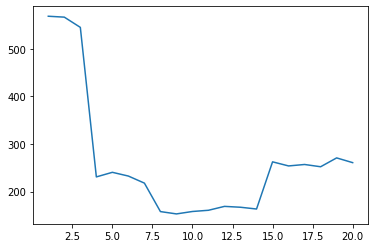

In [55]:
plt.plot(eje_n, errores)
plt.show()

In [56]:
min(errores)

153.21738178178697

In [57]:
eje_n[errores.index(min(errores))]

9

$ $ 

$ Aplicacion \ del \ nuevo \ metodo $

$ $

Este método se aplica justamente como se propuso, en donde obtuvimos que el porcentaje optimo es $ 51 $ y aquí se obtuvo que para este modelo se utilizan 13 variables obteniendo un error de 30.1 

$ $ 

In [58]:
def nuevo_metodo(indices):

    #-------------------------------------------
    
    archivo_2014 = pd.read_csv("2014_Financial_Data.csv")
    archivo_2015 = pd.read_csv("2015_Financial_Data.csv")
    archivo_2016 = pd.read_csv("2016_Financial_Data.csv")
    archivo_2017 = pd.read_csv("2017_Financial_Data.csv")
    archivo_2018 = pd.read_csv("2018_Financial_Data.csv")
    
    #-------------------------------------------
    
    nombres_2014 = []

    for k in archivo_2014:
        nombres_2014.append(k)
    
    nombres_2014.remove(nombres_2014[len(nombres_2014)-1])
    nombres_2014.remove(nombres_2014[0])

    #--------------------------------------------

    nombres_2015 = []

    for k in archivo_2015:
        nombres_2015.append(k)
    
    nombres_2015.remove(nombres_2015[len(nombres_2015)-1])
    nombres_2015.remove(nombres_2015[0])

    #--------------------------------------------

    nombres_2016 = []

    for k in archivo_2016:
        nombres_2016.append(k)
    
    nombres_2016.remove(nombres_2016[len(nombres_2016)-1])
    nombres_2016.remove(nombres_2016[0])

    #--------------------------------------------

    nombres_2017 = []

    for k in archivo_2017:
        nombres_2017.append(k)
    
    nombres_2017.remove(nombres_2017[len(nombres_2017)-1])
    nombres_2017.remove(nombres_2017[0])

    #--------------------------------------------

    nombres_2018 = []

    for k in archivo_2018:
        nombres_2018.append(k)
    
    nombres_2018.remove(nombres_2018[len(nombres_2018)-1])
    nombres_2018.remove(nombres_2018[0])
    
    #--------------------------------------------
    
    eleccion = indices
    
    #--------------------------------------------
    
    nuevos_nombres_2014 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2014.append(nombres_2014[eleccion[j]])
    
    nuevos_nombres_2014.append(nombres_2014[len(nombres_2014)-1])
    
    #--------------------------------------------
    
    nuevos_nombres_2015 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2015.append(nombres_2015[eleccion[j]])
    
    nuevos_nombres_2015.append(nombres_2015[len(nombres_2015)-1])
    
    #--------------------------------------------
    
    nuevos_nombres_2016 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2016.append(nombres_2016[eleccion[j]])
    
    nuevos_nombres_2016.append(nombres_2016[len(nombres_2016)-1])
    
    #--------------------------------------------
    
    nuevos_nombres_2017 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2017.append(nombres_2017[eleccion[j]])
    
    nuevos_nombres_2017.append(nombres_2017[len(nombres_2017)-1])
    
    #--------------------------------------------
    
    nuevos_nombres_2018 = []
    
    for j in range(len(eleccion)):
        nuevos_nombres_2018.append(nombres_2018[eleccion[j]])
    
    nuevos_nombres_2018.append(nombres_2018[len(nombres_2018)-1])
    
    #--------------------------------------------
    
    nuevo_archivo_2014 = archivo_2014.dropna(subset=nuevos_nombres_2014)
    nuevo_archivo_2015 = archivo_2015.dropna(subset=nuevos_nombres_2015)
    nuevo_archivo_2016 = archivo_2016.dropna(subset=nuevos_nombres_2016)
    nuevo_archivo_2017 = archivo_2017.dropna(subset=nuevos_nombres_2017)
    nuevo_archivo_2018 = archivo_2018.dropna(subset=nuevos_nombres_2018)
    
    #--------------------------------------------
    
    data_2014 = []
    
    for k in nuevos_nombres_2014:
        lista = []
        for j in nuevo_archivo_2014[k]:
            lista.append(j)
        data_2014.append(lista)
        
    #--------------------------------------------
    
    data_2015 = []
    
    for k in nuevos_nombres_2015:
        lista = []
        for j in nuevo_archivo_2015[k]:
            lista.append(j)
        data_2015.append(lista)
    
    #--------------------------------------------
    
    data_2016 = []
    
    for k in nuevos_nombres_2016:
        lista = []
        for j in nuevo_archivo_2016[k]:
            lista.append(j)
        data_2016.append(lista)
        
    #--------------------------------------------
    
    data_2017 = []
    
    for k in nuevos_nombres_2017:
        lista = []
        for j in nuevo_archivo_2017[k]:
            lista.append(j)
        data_2017.append(lista)
    
    #--------------------------------------------
    
    data_2018 = []
    
    for k in nuevos_nombres_2018:
        lista = []
        for j in nuevo_archivo_2018[k]:
            lista.append(j)
        data_2018.append(lista)
        
    #--------------------------------------------
    
    X_entrenamiento = []
    Y_entrenamiento = []
    
    for i in range(len(data_2014[0])):
        lista = []
        for j in range(len(data_2014)-1):
            lista.append(data_2014[j][i])
        X_entrenamiento.append(lista)
        Y_entrenamiento.append(data_2014[len(data_2014)-1][i])
    
    for i in range(len(data_2015[0])):
        lista = []
        for j in range(len(data_2015)-1):
            lista.append(data_2015[j][i])
        X_entrenamiento.append(lista)
        Y_entrenamiento.append(data_2015[len(data_2015)-1][i])
    
    for i in range(len(data_2016[0])):
        lista = []
        for j in range(len(data_2016)-1):
            lista.append(data_2016[j][i])
        X_entrenamiento.append(lista)
        Y_entrenamiento.append(data_2016[len(data_2016)-1][i])
    
    for i in range(len(data_2017[0])):
        lista = []
        for j in range(len(data_2017)-1):
            lista.append(data_2017[j][i])
        X_entrenamiento.append(lista)
        Y_entrenamiento.append(data_2017[len(data_2017)-1][i])
    
    #--------------------------------------------
    
    X_test = []
    Y_test = []
    
    for i in range(len(data_2018[0])):
        lista = []
        for j in range(len(data_2018)-1):
            lista.append(data_2018[j][i])
        X_test.append(lista)
        Y_test.append(data_2018[len(data_2018)-1][i])
        
    #--------------------------------------------
    
    dato_X = np.array(X_entrenamiento)
    dato_Y = np.array(Y_entrenamiento)
    
    regresion = LinearRegression().fit(dato_X, dato_Y)
    
    predicciones = regresion.predict(np.array(X_test))
    
    #--------------------------------------------
    
    errores = []
    
    for i in range(len(predicciones)):
        errores.append(abs(float(predicciones[i]) - Y_test[i]))
    
    error = np.mean(errores)
    
    #--------------------------------------------
    
    #Calculo del valor p
    
    mod = sm.OLS(dato_Y,dato_X)
    fii = mod.fit()
    p_values = list(fii.summary2().tables[1]['P>|t|'])
    
    #--------------------------------------------
    
    t = p_values.index(min(p_values))
    indices[t]
    
    return [error, indices[t], min(p_values)]

In [59]:
mejores_indices = []

p = 0.1

tiempo_total = 0

for i in range(220):
    start = time.time()
    
    output = nuevo_metodo([i])
    
    mejores_indices.append([output[1], output[2]])
    end = time.time()
    
    tiempo_total = tiempo_total + (end-start)
    
    if i % 20 == 0:
        
        print("Iteración: ", i)
        print("Tiempo: ", tiempo_total)
        print("-----------------")

Iteración:  0
Tiempo:  1.4301183223724365
-----------------
Iteración:  20
Tiempo:  32.45317101478577
-----------------
Iteración:  40
Tiempo:  64.4096667766571
-----------------


C:\Users\56977\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
C:\Users\56977\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
C:\Users\56977\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
C:\Users\56977\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
C:\Users\56977\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


Iteración:  60
Tiempo:  97.93136143684387
-----------------
Iteración:  80
Tiempo:  131.8084020614624
-----------------


C:\Users\56977\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


Iteración:  100
Tiempo:  167.12436437606812
-----------------


C:\Users\56977\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))
C:\Users\56977\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  "anyway, n=%i" % int(n))


Iteración:  120
Tiempo:  200.914235830307
-----------------


C:\Users\56977\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


Iteración:  140
Tiempo:  234.42701506614685
-----------------
Iteración:  160
Tiempo:  268.2550001144409
-----------------


C:\Users\56977\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model
C:\Users\56977\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1657: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


Iteración:  180
Tiempo:  301.56942558288574
-----------------
Iteración:  200
Tiempo:  335.3934803009033
-----------------


In [60]:
def mejores_indices_umbral(p):
    indices_definitivos = []
    for i in range(len(mejores_indices)):
        if mejores_indices[i][1] <= p:
            indices_definitivos.append(mejores_indices[i][0])
    return indices_definitivos

In [61]:
errores = []
eje_p = []
P = 70

tiempo_total = 0

for p in range(P):
    
    start = time.time()
    
    prob = p/100
    errores.append(nuevo_metodo(mejores_indices_umbral(prob))[0])
    eje_p.append(p)
    
    end = time.time()
    
    print("Iteración: ", p)
    print("Tiempo: ", end-start)
    print("--------")
    
    tiempo_total = tiempo_total + (end-start)

print("--------")
print("Tiempo total: ", tiempo_total)

Iteración:  0
Tiempo:  1.9047844409942627
--------
Iteración:  1
Tiempo:  1.2121796607971191
--------
Iteración:  2
Tiempo:  2.1677489280700684
--------
Iteración:  3
Tiempo:  1.209355115890503
--------
Iteración:  4
Tiempo:  1.9075441360473633
--------
Iteración:  5
Tiempo:  1.7450075149536133
--------
Iteración:  6
Tiempo:  1.3483543395996094
--------
Iteración:  7
Tiempo:  2.148416757583618
--------
Iteración:  8
Tiempo:  1.0712032318115234
--------
Iteración:  9
Tiempo:  1.3440051078796387
--------
Iteración:  10
Tiempo:  2.4054760932922363
--------
Iteración:  11
Tiempo:  1.825451374053955
--------
Iteración:  12
Tiempo:  1.7357850074768066
--------
Iteración:  13
Tiempo:  2.1952197551727295
--------
Iteración:  14
Tiempo:  1.5691516399383545
--------
Iteración:  15
Tiempo:  2.2952282428741455
--------
Iteración:  16
Tiempo:  1.0428946018218994
--------
Iteración:  17
Tiempo:  2.2157480716705322
--------
Iteración:  18
Tiempo:  2.019960403442383
--------
Iteración:  19
Tiempo:  1.

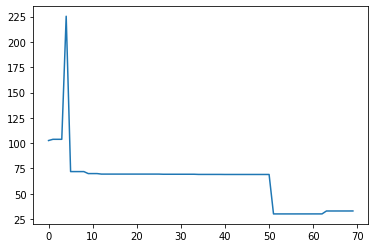

In [62]:
plt.plot(eje_p, errores)
plt.show()

In [63]:
min(errores)

30.063586450562106

In [64]:
eje_p[errores.index(min(errores))]

51

In [65]:
# 30 unidades es el minimo error y se encuentra cuando 

In [66]:
indices_definitivos = []
for i in range(len(mejores_indices)):
    if mejores_indices[i][1] <= 0.51:
        indices_definitivos.append(mejores_indices[i][0])

In [67]:
indices_definitivos

[21, 68, 74, 85, 91, 152, 153, 164, 172, 199, 200, 201, 210]

$ $

$ Analisis \ de \ Resultados $ 

$ $

Notemos que para este caso random forest funciona mal en comparación al método polinomial y al método propuesto, y esto es porque la clave en este caso es encontrar las variables que son más significativas para predecir. Cuando comparamos la regresión polinomial notamos que el mejor caso es un polinomio de grado uno con un error mayor a 40, sin embargo, en nuestro metodo propuesto logramos un error cercano a 30, es decir que es el más eficiente de todos, y esto es justamente porque en este método encontramos estadisticamente las variables más significativas

$ $